In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7168      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 17,570
Trainable params: 17,570
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 2s 80ms/step - loss: 0.2676 - accuracy: 0.7769 - val_loss: 0.2224 - val_accuracy: 0.8468
Epoch 2/100
5/5 [===========================

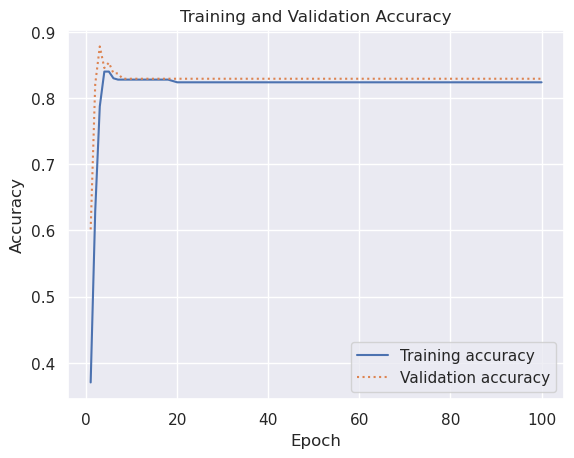

1/1 [==============================] - 0s 113ms/step


/tmp/ipykernel_21/30731265.py:109: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_df.fillna(df.mean(), inplace=True)


In [2]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import keras.backend as K

# Read the CSV file into a DataFrame
df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")

# Fill missing values with the mean
df.fillna(df.mean(), inplace=True)

# Split the data into input features (x) and labels (y)
# and drop non-numeric values
x = df.drop(['Id', 'Class', 'EJ'], axis=1)
y = df['Class']

# Convert labels to one-hot encoded vectors
y_one_hot = to_categorical(y, num_classes=2)

# Scale the data using StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Define the model architecture
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=len(x.columns)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='sigmoid'))  # Change the number of units to 2

# Define the custom loss function
def balanced_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    class_0_loss = -K.mean(y_true[:, 0] * K.log(y_pred[:, 0]))
    class_1_loss = -K.mean(y_true[:, 1] * K.log(y_pred[:, 1]))
    return (class_0_loss + class_1_loss) / 2

# Compile the model with the balanced logarithmic loss
model.compile(loss=balanced_log_loss, optimizer='adam', metrics=['accuracy'])
model.summary()

# Perform KFold cross-validation
kf = KFold(n_splits=5, random_state=0, shuffle=True)

best_val_loss = float('inf')
best_epoch = 0

for train_index, val_index in kf.split(x_scaled):
    x_train, x_val = x_scaled[train_index], x_scaled[val_index]
    y_train, y_val = y_one_hot[train_index], y_one_hot[val_index]

    # Define the model architecture
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=len(x.columns)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))  # Change the number of units to 2
    model.compile(loss=balanced_log_loss, optimizer='adam', metrics=['accuracy'])
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

    # Train the model
    hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=100, callbacks=[early_stopping])
    
    # Track the best epoch based on validation loss
    if np.min(hist.history['val_loss']) < best_val_loss:
        best_val_loss = np.min(hist.history['val_loss'])
        best_epoch = np.argmin(hist.history['val_loss']) + 1

# Train the final model with the best epoch
model.fit(x_scaled, y_one_hot, epochs=best_epoch, batch_size=100)

# Print training accuracy
print(hist.history['accuracy'])

# Print training loss
print(hist.history['loss'])

# Print validation loss
print(hist.history['val_loss'])

# Print validation accuracy
print(hist.history['val_accuracy'])

# Plot training and validation accuracy
sns.set()
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Load the test data
test_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")

# Fill missing values with the mean
test_df.fillna(df.mean(), inplace=True)

# Scale the test data using StandardScaler
test_x_scaled = scaler.transform(test_df.drop(['Id', 'EJ'], axis=1))

# Predict the probabilities for the test data using the trained model
probabilities = model.predict(test_x_scaled)

# Clip the predicted probabilities
probabilities = np.clip(probabilities, 1e-15, 1 - 1e-15)

# Rescale the probabilities
probabilities /= probabilities.sum(axis=1, keepdims=True)

# Create a DataFrame for the predictions
sample = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
sample['class_1'] = probabilities[:, 1]  # Probability for class 1
sample['class_0'] = probabilities[:, 0]  # Probability for class 0
sample.to_csv('submission.csv', index=False)